In [363]:
import abc
from typing import Union
import numpy as np
import torch
from tqdm import tqdm

class CoresetSampler():
    def __init__(
        self,
        distance_type: str,
        coreset_size: float,
        device: torch.device,
        number_of_starting_points: int = 10,
        coreset_search_dimension_map = 128,
    ):
        """Greedy Coreset sampling base class."""

        self.device = device
        self.distance_type = distance_type
        self.coreset_search_dimension_map = coreset_search_dimension_map
        self.coreset_size = coreset_size
        self.number_of_starting_points = number_of_starting_points
        print("CoresetSampler distance type: ", self.distance_type)
        
    def _store_type(self, features: Union[torch.Tensor, np.ndarray]) -> None:
        self.features_is_numpy = isinstance(features, np.ndarray)
        if not self.features_is_numpy:
            self.features_device = features.device

    def _restore_type(self, features: torch.Tensor) -> Union[torch.Tensor, np.ndarray]:
        if self.features_is_numpy:
            return features.cpu().numpy()
        return features.to(self.features_device)
    
    def _reduce_features(self, features):
        if features.shape[1] == self.coreset_search_dimension_map:
            return features
        mapper = torch.nn.Linear(
            features.shape[1], self.coreset_search_dimension_map, bias=False
        )
        _ = mapper.to(self.device)
        features = features.to(self.device)
        return mapper(features)

    def run(
        self, features: Union[torch.Tensor, np.ndarray]
    ) -> Union[torch.Tensor, np.ndarray]:
        """Subsamples features using Greedy Coreset.

        Args:
            features: [N x D]
        """

        self._store_type(features)
        if isinstance(features, np.ndarray):
            features = torch.from_numpy(features)
        reduced_features = self._reduce_features(features)
        sample_indices = self._compute_greedy_coreset_indices(reduced_features)
        features = features[sample_indices]
        return self._restore_type(features)
    
    def _compute_batchwise_differences(self, matrix_a: torch.Tensor, matrix_b: torch.Tensor):
        if self.distance_type == "euclidean":
            return self._compute_euclidean_distances_original(matrix_a, matrix_b)
        
        if self.distance_type == "euclidean_new":
            return self._compute_batchwise_euclidean_distances_new(matrix_a, matrix_b)
        
        if self.distance_type == "cosine":
            return self._compute_batchwise_cosine_distance(matrix_a, matrix_b)
        
        if self.distance_type == "manhatten":
            return self._compute_minkowski_distance(matrix_a, matrix_b, p=1)
        
        if self.distance_type == "minkowski3":
            return self._compute_minkowski_distance(matrix_a, matrix_b, p=3)
        
    @staticmethod
    def _compute_euclidean_distances_original(
        matrix_a: torch.Tensor, matrix_b: torch.Tensor
    ) -> torch.Tensor:
        """Computes batchwise Euclidean distances using PyTorch."""
        a_times_a = matrix_a.unsqueeze(1).bmm(matrix_a.unsqueeze(2)).reshape(-1, 1)
        b_times_b = matrix_b.unsqueeze(1).bmm(matrix_b.unsqueeze(2)).reshape(1, -1)
        a_times_b = matrix_a.mm(matrix_b.T)

        return (-2 * a_times_b + a_times_a + b_times_b).clamp(0, None).sqrt()
    
    @staticmethod
    def _compute_batchwise_euclidean_distances_new(matrix_a, matrix_b):
        # Squared norms of each row in matrix_a and matrix_b
        a_times_a = (matrix_a ** 2).sum(dim=1, keepdim=True)
        b_times_b = (matrix_b ** 2).sum(dim=1, keepdim=True).T

        # Dot product between each pair of rows from matrix_a and matrix_b
        a_times_b = matrix_a @ matrix_b.T

        # Compute the squared Euclidean distances
        distances_squared = a_times_a - 2 * a_times_b + b_times_b

        # Ensure distances are non-negative and compute the Euclidean distances
        distances = distances_squared.clamp(min=0).sqrt()

        return distances
    
    @staticmethod
    def _compute_batchwise_cosine_distance(matrix_a, matrix_b):
    
        set1_normalized = matrix_a / matrix_a.norm(dim=1)[:, None]
        set2_normalized = matrix_b / matrix_b.norm(dim=1)[:, None]

        # Calculate the cosine similarity using dot product
        cosine_similarities = torch.mm(set1_normalized, set2_normalized.t())

        # Calculate the cosine distances (1 - cosine similarity)
        cosine_distances = 1 - cosine_similarities

        return cosine_distances
    
    
    @staticmethod
    def _compute_minkowski_distance(matrix_a, matrix_b, p=3):
        # Broadcasting to compute pairwise distances
        distances = torch.cdist(matrix_a, matrix_b, p=p)
        return distances

    def _compute_greedy_coreset_indices(self, features: torch.Tensor) -> np.ndarray:
        """Runs approximate iterative greedy coreset selection.

        This greedy coreset implementation does not require computation of the
        full N x N distance matrix and thus requires a lot less memory, however
        at the cost of increased sampling times.

        Args:
            features: [NxD] input feature bank to sample.
        """
        print("features.shape", features.shape)
        number_of_starting_points = np.clip(
            self.number_of_starting_points, None, len(features)
        )
        start_points = np.random.choice(
            len(features), number_of_starting_points, replace=False
        ).tolist()

        approximate_distance_matrix = self._compute_batchwise_differences(
            features, features[start_points]
        )
        approximate_coreset_anchor_distances = torch.mean(
            approximate_distance_matrix, axis=-1
        ).reshape(-1, 1)
        coreset_indices = []
        
        num_coreset_samples = int(self.coreset_size)

        with torch.no_grad():
            for _ in tqdm(range(num_coreset_samples), desc="Subsampling..."):
                select_idx = torch.argmax(approximate_coreset_anchor_distances).item()
                coreset_indices.append(select_idx)
                coreset_select_distance = self._compute_batchwise_differences(
                    features, features[select_idx : select_idx + 1]  # noqa: E203
                )
                approximate_coreset_anchor_distances = torch.cat(
                    [approximate_coreset_anchor_distances, coreset_select_distance],
                    dim=-1,
                )
                approximate_coreset_anchor_distances = torch.min(
                    approximate_coreset_anchor_distances, dim=1
                ).values.reshape(-1, 1)

        return np.array(coreset_indices)

In [247]:
import copy
import os
import pickle
from typing import List
from typing import Union
from xml.dom import NotFoundErr

import faiss
import numpy as np
import scipy.ndimage as ndimage
import torch
import torch.nn.functional as F


class FaissNNnew(object):
    def __init__(self, distance_type, on_gpu: bool = False, num_workers: int = 4) -> None:
        """FAISS Nearest neighbourhood search.

        Args:
            on_gpu: If set true, nearest neighbour searches are done on GPU.
            num_workers: Number of workers to use with FAISS for similarity search.
        """
        faiss.omp_set_num_threads(num_workers)
        self.distance_type = distance_type
        self.on_gpu = on_gpu
        self.search_index = None
        print("FaissNN distance type: ", self.distance_type)

    def _gpu_cloner_options(self):
        return faiss.GpuClonerOptions()

    def _index_to_gpu(self, index):
        if self.on_gpu:
            # For the non-gpu faiss python package, there is no GpuClonerOptions
            # so we can not make a default in the function header.
            return faiss.index_cpu_to_gpu(
                faiss.StandardGpuResources(), 0, index, self._gpu_cloner_options()
            )
        return index

    def _index_to_cpu(self, index):
        if self.on_gpu:
            return faiss.index_gpu_to_cpu(index)
        return index

    @staticmethod
    def normalize_L2(vectors):
        return vectors
            
    def _create_index(self, dimension):
        if self.on_gpu:
            if self.distance_type=="euclidean":
                return faiss.GpuIndexFlatL2(
                    faiss.StandardGpuResources(), dimension, faiss.GpuIndexFlatConfig()
                )
            elif self.distance_type=="cosine":
                print("returning the IP index")
                return faiss.GpuIndexFlatIP(faiss.StandardGpuResources(), 
                                            dimension, 
                                            faiss.GpuIndexFlatConfig())  # or faiss.IndexFlatIP(d) for CPU
        else:
            if self.distance_type=="euclidean":
                return faiss.IndexFlatL2(dimension)
            elif self.distance_type=="cosine":
                print("returning the IP index")
                return faiss.IndexFlatIP(dimension)  # or faiss.IndexFlatIP(d) for CPU
                
        raise NotImplemented("unimplemented distance type selected")
        

    def fit(self, features: np.ndarray) -> None:
        """
        Adds features to the FAISS search index.

        Args:
            features: Array of size NxD.
        """
        if self.search_index:
            self.reset_index()
        self.search_index = self._create_index(features.shape[-1])
        self._train(self.search_index, features)
        
        print("\n\n\nFeatures are being fit to the FAISNNnew\n\n\n")
        self.raw_features = features
        if self.distance_type=="cosine":
            features = self.normalize_L2(features)
            
        self.search_index.add(features)

    def _train(self, _index, _features):
        pass

    def run(
        self,
        n_nearest_neighbours,
        query_features: np.ndarray,
        index_features: np.ndarray = None,
    ) -> Union[np.ndarray, np.ndarray, np.ndarray]:
        """
        Returns distances and indices of nearest neighbour search.

        Args:
            query_features: Features to retrieve.
            index_features: [optional] Index features to search in.
        """
        self.on_gpu = False
        if index_features is None:
            if self.distance_type == "cosine":
                query_features = self.normalize_L2(query_features)
                return 1/self.search_index.search(query_features, n_nearest_neighbours)
            else:
                return self.search_index.search(query_features, n_nearest_neighbours)

    def save(self, filename: str) -> None:
        faiss.write_index(self._index_to_cpu(self.search_index), filename)
        
    def load(self, filename: str) -> None:
        self.search_index = self._index_to_gpu(faiss.read_index(filename))

    def reset_index(self):
        if self.search_index:
            self.search_index.reset()
            self.search_index = None

In [365]:
'''
Based on code found here: https://github.com/amazon-science/patchcore-inspection
And based on the the paper: 
https://arxiv.org/pdf/2106.08265v2.pdf
@misc{roth2021total,
      title={Towards Total Recall in Industrial Anomaly Detection},
      author={Karsten Roth and Latha Pemula and Joaquin Zepeda and Bernhard Schölkopf and Thomas Brox and Peter Gehler},
      year={2021},
      eprint={2106.08265},
      archivePrefix={arXiv},
      primaryClass={cs.CV}
}
'''
import numpy as np
import torch
import os
import pickle
import sys
sys.path.append("/mnt/faster0/adjt20/VisionAD")
from algos.model_wrapper import ModelWrapper
from tqdm import tqdm
from algos.patchcore import backbones
from algos.patchcore import common
from algos.patchcore.patchcore import PatchMaker
# from algos.patchcore import sampler
from algos.patchcore import utils
import tempfile
import shutil

class WrapperPatchCorePlus(ModelWrapper):
    def  __init__(self, load_model_params=True, **params):
        super(ModelWrapper, self).__init__()
        if load_model_params:
            self.load_model_params(**params)
        self.default_segmentation = "segmentations"
        self.default_score = "scores"

    def load_model_params(self, **params):
        self.__name__ = "PatchCore"
        self.params = params
        sampler = CoresetSampler(distance_type = self.params["distance_type"],
                                         coreset_size = self.params["coreset_size"], 
                                         device       = self.params["device"], 
                                         coreset_search_dimension_map = self.params["coreset_search_dimension_map"])
        
        size = (3,params["input_size"],params["input_size"])
        
        self.PatchCore_list = patch_core(params)(size, sampler, params["device"])

        for PatchCore in self.PatchCore_list:
            torch.cuda.empty_cache()
            if PatchCore.backbone.seed is not None:
                utils.fix_seeds(PatchCore.backbone.seed, params["device"])

    def save_model(self, location):
        os.makedirs(location, exist_ok=True)
        self.save_params(location)
        os.makedirs(os.path.join(location, "features"), exist_ok=True)
        for i, PatchCore in enumerate(self.PatchCore_list):
            prepend = str(f"ensemble{i}_")
            PatchCore.save_to_path(os.path.join(location, "features"), prepend)

#     def load_model(self, location, **kwargs):
#         params = self.load_params(location)
#         self.load_model_params(**params)

#         faiss_on_gpu = False
#         faiss_num_workers = 8
#         device = params["device"]

#         files = os.listdir(os.path.join(location, "features"))
#         self.PatchCore_list = []
#         for i, file in enumerate(files):
#             if not "patchcore_params.pkl" in file:
#                 continue
#             prepend = file.split("_")[0]+"_"
#             nn_method = common.FaissNN(faiss_on_gpu, faiss_num_workers)
#             patchcore_instance = PatchCore(device)
#             patchcore_instance.load_from_path(os.path.join(location, "features"), device, nn_method, prepend=prepend)
#             self.PatchCore_list.append(patchcore_instance)

    def train_one_epoch(self):
        '''
        This model actually does no 'training'. It just gathers the features using the pre-trained backbone.
        This action of doing this makes more sense in the pre_eval_processing part
        '''
        pass

    def pre_eval_processing(self,):
        for i, PatchCore in enumerate(self.PatchCore_list):
            PatchCore.fit(self.dataloader_train)

        ''' 
        Save the model
        Reload it with faiss_on_gpu = False
        A bug in faiss means it keeps crashing during inference when a GPU is used. 
        The only way I found around this is to save it and 
        reload it with faiss_on_gpu=False, and device="cpu" 
        '''
    
        if not self.params["nn_code"]=="faiss":
            pass
        else:
            location = os.path.join(tempfile.gettempdir(), f"patchcore_internal_save_point_{str(np.random.rand())[2:]}")
            if os.path.exists(location): 
                shutil.rmtree(location)
            while os.path.exists(location): 
                pass
            self.save_model(location)
            self.load_model(location, faiss_on_gpu=False, faiss_num_workers=8, device="cpu")
            shutil.rmtree(location)
            while os.path.exists(location):
                pass

    def _predict(self, PatchCore, dataloader, len_dataloader, verbose=False, limit=None):
        paths_ret = []
        scores    = []
        for ind, (data, _) in tqdm(enumerate(dataloader), total=len_dataloader):
            torch.cuda.empty_cache()
            _scores, _segmentations = PatchCore._predict(data)
            _scores, _segmentations = _scores.to("cpu"), _segmentations.to("cpu")
            scores += [score.item() for score in _scores]

            if ind==0:
                segmentations_set = _segmentations
            else:
                segmentations_set = torch.vstack([segmentations_set, _segmentations])
            if limit:
                if ind>limit:
                    break
        return scores, segmentations_set

    def eval_outputs_dataloader(self, dataloader, len_dataloader, verbose=False, limit=None):
        aggregator = {"scores": [], "segmentations": []}
        for i, PatchCore in enumerate(self.PatchCore_list):
            
            torch.cuda.empty_cache()
            PatchCore.anomaly_scorer.nn_method.faiss_on_gpu = False            
            scores, segmentationss = self._predict(
                PatchCore,
                dataloader,
                len_dataloader,
                verbose=verbose,
                limit=limit,
            )

            # targets and paths are the same whichever model we extract from
            # therefore we only need to stack scores and segmentations for manipulation later
            aggregator["scores"].append(scores)
            aggregator["segmentations"].append(segmentationss)

            
        scores = np.array(aggregator["scores"])
        # min_scores = scores.min(axis=-1).reshape(-1, 1)
        # max_scores = scores.max(axis=-1).reshape(-1, 1)
        # scores_normalised = (scores - min_scores) / (max_scores - min_scores)
        # scores_normalised = np.mean(scores_normalised, axis=0)

        segmentations = torch.stack(aggregator["segmentations"]).numpy()

        # the normalisation of the segmentations and scores is removed
        # it makes no sense when the regular and anomaly dataloader are evaluated seperately
        segmentations = np.mean(segmentations, axis=0)
        scores        = np.mean(scores, axis=0)

        return {"segmentations":torch.tensor(segmentations).unsqueeze(1)}, {"scores": scores}

class PatchCore(torch.nn.Module):
    def __init__(self, device):
        """PatchCore anomaly detection class."""
        super(PatchCore, self).__init__()
        self.device = device

    def load(
        self,
        backbone,
        layers_to_extract_from,
        device,
        input_shape,
        pretrain_embed_dimension,
        target_embed_dimension,
        patchsize=3,
        patchstride=1,
        anomaly_score_num_nn=1,
        featuresampler=None,
        nn_method=None,
        nn_code="faiss",
        **kwargs,
    ):
        self.backbone = backbone.to(device)
        self.layers_to_extract_from = layers_to_extract_from
        self.input_shape = input_shape

        self.device = device
        self.patch_maker = PatchMaker(patchsize, stride=patchstride)

        self.forward_modules = torch.nn.ModuleDict({})

        feature_aggregator = common.NetworkFeatureAggregator(
            self.backbone, self.layers_to_extract_from, self.device
        )
        feature_dimensions = feature_aggregator.feature_dimensions(input_shape)
        self.forward_modules["feature_aggregator"] = feature_aggregator

        preprocessing = common.Preprocessing(
            feature_dimensions, pretrain_embed_dimension
        )
        self.forward_modules["preprocessing"] = preprocessing

        self.target_embed_dimension = target_embed_dimension
        preadapt_aggregator = common.Aggregator(
            target_dim=target_embed_dimension
        )

        _ = preadapt_aggregator.to(self.device)

        self.forward_modules["preadapt_aggregator"] = preadapt_aggregator

        self.anomaly_scorer = common.NearestNeighbourScorer(
            n_nearest_neighbours=anomaly_score_num_nn, nn_method=nn_method
        )

        self.anomaly_segmentor = common.RescaleSegmentor(
            device=self.device, target_size=input_shape[-2:]
        )

        self.featuresampler = featuresampler
        
        self.nn_code = nn_code 
        
    def embed(self, data):
        if isinstance(data, torch.utils.data.DataLoader):
            features = []
            for image in data:
                if isinstance(image, dict):
                    image = image["image"]
                with torch.no_grad():
                    input_image = image.to(torch.float).to(self.device)
                    features.append(self._embed(input_image))
            return features
        return self._embed(data)

    def _embed(self, images, detach=True, provide_patch_shapes=False):
        """Returns feature embeddings for images."""

        def _detach(features):
            if detach:
                return [x.detach().cpu().numpy() for x in features]
            return features

        _ = self.forward_modules["feature_aggregator"].eval()
        with torch.no_grad():
            features = self.forward_modules["feature_aggregator"](images)

        features = [features[layer] for layer in self.layers_to_extract_from]

        features = [
            self.patch_maker.patchify(x, return_spatial_info=True) for x in features
        ]
        patch_shapes = [x[1] for x in features]
        features = [x[0] for x in features]
        ref_num_patches = patch_shapes[0]

        for i in range(1, len(features)):
            _features = features[i]
            patch_dims = patch_shapes[i]

            # TODO(pgehler): Add comments
            _features = _features.reshape(
                _features.shape[0], patch_dims[0], patch_dims[1], *_features.shape[2:]
            )
            _features = _features.permute(0, -3, -2, -1, 1, 2)
            perm_base_shape = _features.shape
            _features = _features.reshape(-1, *_features.shape[-2:])
            _features = F.interpolate(
                _features.unsqueeze(1),
                size=(ref_num_patches[0], ref_num_patches[1]),
                mode="bilinear",
                align_corners=False,
            )
            _features = _features.squeeze(1)
            _features = _features.reshape(
                *perm_base_shape[:-2], ref_num_patches[0], ref_num_patches[1]
            )
            _features = _features.permute(0, -2, -1, 1, 2, 3)
            _features = _features.reshape(len(_features), -1, *_features.shape[-3:])
            features[i] = _features
        features = [x.reshape(-1, *x.shape[-3:]) for x in features]

        # As different feature backbones & patching provide differently
        # sized features, these are brought into the correct form here.
        features = self.forward_modules["preprocessing"](features)
        features = self.forward_modules["preadapt_aggregator"](features)

        if provide_patch_shapes:
            return _detach(features), patch_shapes
        return _detach(features)

    def fit(self, training_dataloader):
        """PatchCore training.

        This function computes the embeddings of the training data and fills the
        memory bank of SPADE.
        """
        self._fill_memory_bank(training_dataloader)

    def _fill_memory_bank(self, training_dataloader):
        """Computes and sets the support features for SPADE."""
        _ = self.forward_modules.eval()

        def _image_to_features(input_image):
            with torch.no_grad():
                input_image = input_image.to(torch.float).to(self.device)
                return self._embed(input_image)

        features = []
        for ind, (data, targets, paths) in enumerate(training_dataloader):
            features.append(_image_to_features(data))

        features = np.concatenate(features, axis=0)
        features = self.featuresampler.run(features)

        if self.nn_code=="faiss":
            self.anomaly_scorer.fit(detection_features=[features])
        else:
            self.coreset_feaures = torch.tensor(features).to(self.device)
            
    def _predict(self, images):
        """Infer score and mask for a batch of images."""
        images = images.to(torch.float).to(self.device)
        _ = self.forward_modules.eval()

        batchsize = images.shape[0]
        
        with torch.no_grad():
            features, patch_shapes = self._embed(images, provide_patch_shapes=True)
            features = np.asarray(features)
            
            if self.nn_code=="faiss":
                patch_scores = image_scores = self.anomaly_scorer.predict([features])[0]
            else:
#                 patch_scores = image_scores = self.anomaly_scorer.predict([features])[0] 
                
                distances_all = self.featuresampler._compute_batchwise_differences(
                                                                        self.coreset_feaures, 
                                                                        torch.tensor(features).to(self.device))
                patch_scores = image_scores = distances_all.min(0).values
                image_scores = image_scores.to("cpu").numpy()
                
                
            image_scores = self.patch_maker.unpatch_scores(
                image_scores, batchsize=batchsize
            )
            image_scores = image_scores.reshape(*image_scores.shape[:2], -1)
            image_scores = self.patch_maker.score(image_scores)

            patch_scores = self.patch_maker.unpatch_scores(
                patch_scores, batchsize=batchsize
            )
            scales = patch_shapes[0]
            patch_scores = patch_scores.reshape(batchsize, scales[0], scales[1])

            masks = self.anomaly_segmentor.convert_to_segmentation(patch_scores)

        return torch.tensor(np.array(image_scores)), torch.tensor(np.array(masks))

    @staticmethod
    def _params_file(filepath, prepend=""):
        return os.path.join(filepath, prepend + "patchcore_params.pkl")

    def save_to_path(self, save_path: str, prepend: str = "") -> None:
#         LOGGER.info("Saving PatchCore data.")
        self.anomaly_scorer.save(
            save_path, save_features_separately=False, prepend=prepend
        )
        patchcore_params = {
            "backbone.name": self.backbone.name,
            "layers_to_extract_from": self.layers_to_extract_from,
            "input_shape": self.input_shape,
            "pretrain_embed_dimension": self.forward_modules[
                "preprocessing"
            ].output_dim,
            "target_embed_dimension": self.forward_modules[
                "preadapt_aggregator"
            ].target_dim,
            "patchsize": self.patch_maker.patchsize,
            "patchstride": self.patch_maker.stride,
            "anomaly_scorer_num_nn": self.anomaly_scorer.n_nearest_neighbours,
        }
        with open(self._params_file(save_path, prepend), "wb") as save_file:
            pickle.dump(patchcore_params, save_file, pickle.HIGHEST_PROTOCOL)
            
    def load_from_path(
        self,
        load_path: str,
        device: torch.device,
        nn_method: common.FaissNN(False, 4),
        prepend: str = "",
    ) -> None:
        LOGGER.info("Loading and initializing PatchCore.")
        with open(self._params_file(load_path, prepend), "rb") as load_file:
            patchcore_params = pickle.load(load_file)
        patchcore_params["backbone"] = backbones.load(
            patchcore_params["backbone.name"]
        )
        patchcore_params["backbone"].name = patchcore_params["backbone.name"]
        del patchcore_params["backbone.name"]
        self.load(**patchcore_params, device=device, nn_method=nn_method)

        self.anomaly_scorer.load(load_path, prepend)

def patch_core(params):
    pretrain_embed_dimension = params["pretrain_embed_dimension"]
    target_embed_dimension = params["target_embed_dimension"]
    preprocessing = params["preprocessing"]
    aggregation = params["aggregation"]
    patchsize = params["patchsize"]
    patchscore = params["patchscore"]
    patchstride = params["patchstride"]
    patchoverlap = params["patchoverlap"]
    anomaly_scorer_num_nn = params["anomaly_scorer_num_nn"]
    patchsize_aggregate = params["patchsize_aggregate"]
    faiss_on_gpu = params["faiss_on_gpu"]
    faiss_num_workers = params["faiss_num_workers"]
    distance_type  = params["distance_type"]
    nn_code = params["nn_code"]
    backbone_names_layers = params["backbone_names_layers"]

    def get_patchcore(input_shape, sampler, device):
        loaded_patchcores = []


        for backbone_name, layers in backbone_names_layers.items():
            backbone_seed = None
            if ".seed-" in backbone_name:
                backbone_name, backbone_seed = backbone_name.split(".seed-")[0], int(
                    backbone_name.split("-")[-1]
                )
            backbone = backbones.load(backbone_name)
            backbone.name, backbone.seed = backbone_name, backbone_seed
            nn_method = FaissNNnew(distance_type, faiss_on_gpu, faiss_num_workers)

            patchcore_instance = PatchCore(device)
            patchcore_instance.load(
                backbone=backbone,
                layers_to_extract_from=layers,
                device=device,
                input_shape=input_shape,
                pretrain_embed_dimension=pretrain_embed_dimension,
                target_embed_dimension=target_embed_dimension,
                patchsize=patchsize,
                featuresampler=sampler,
                patchstride=patchstride,
                anomaly_scorer_num_nn=anomaly_scorer_num_nn,
                nn_method=nn_method,
                nn_code=nn_code,
            )
            loaded_patchcores.append(patchcore_instance)
        print("len(loaded_patchcores):", len(loaded_patchcores))
        return loaded_patchcores
    return get_patchcore

In [366]:
from data.configure_dataset import load_dataset
# from algos.patchcore.algo_class import WrapperPatchCore
from algos.patchcore._defaultconfigs import patchcore_default_model_params
from torchvision import transforms
from data.load_image_data import create_dataloaders, make_unnormalise
from wrapper.wrapper import run_metrics
from data.configure_dataset import load_dataset
from PIL import Image

image_size = 256

def get_dataloaders(dataset_key, ad_device):
    dataset = load_dataset(dataset_key)

    model_parameters = {"model_params": patchcore_default_model_params,
                        "epochs": 1,
                        "training_transformations":  transforms.Compose([]),
                        "training_transformation_string": "transforms.Compose([])",
                        "identical_transforms": transforms.Compose([transforms.Resize((image_size, image_size), 
                                                                    interpolation=Image.NEAREST),
                                                                    ]),
                        "batch_size": 8,
                        "save_model_every_n_epochs": None,
                        "save_heatmaps_n_epochs": 0,
                        "evaluate_n_epochs": 0,
                        "test_batch_size": 8,
                        "use_gpu": True,
                        }

    model_parameters["pre_pro_transforms"] = transforms.Compose([transforms.Normalize(mean=dataset['mean'], 
                                                                                      std=dataset['std'])])

    dataloader_train, dataloader_regular_test, dataloader_novel_test = create_dataloaders(                                                 
                                                            pre_pro_transforms=model_parameters["pre_pro_transforms"], 
                                                            training_transformations=model_parameters["training_transformations"],
                                                            identical_transforms=model_parameters["identical_transforms"],
                                                            batch_size = 8,
                                                            shuffle = True,
                                                            device = ad_device, 
                                                            unnormalise = make_unnormalise(mean=dataset['mean'], 
                                                                                           std=dataset['std']),
                                                            test_batch_size = model_parameters["test_batch_size"],
                                                            **dataset)
    
    return dataloader_train, dataloader_regular_test, dataloader_novel_test 

In [367]:
params =  {"results_path":"test_results", #, type=str)
            "seed":0, #, ,type=int, default=0, show_default=True)
            "log_group":"group", #, type=str, default="group")
            "log_project":"project", #, type=str, default="project")
            "backbone_names_layers": {"wideresnet50": ["layer2", "layer3"]}, # each item must be a list of layers
            "pretrain_embed_dimension":1024, #, type=int, default=1024)
            "target_embed_dimension":1024, #, type=int, default=1024)
            "preprocessing":"mean", #, type=click.Choice(["mean", "conv"]), default="mean")
            "aggregation":"mean", #, type=click.Choice(["mean", "mlp"]), default="mean")
            "anomaly_scorer_num_nn":5,#, ,type=int, default=5)
            "patchsize":3, #, ,type=int, default=3)
            "patchstride":1,
            "patchscore":"max", # , type=str, default="max")
            "patchoverlap":0.0 ,#, type=float, default=0.0)
            "patchsize_aggregate":[] ,#, "-pa", type=int, multiple=True, default=[])
            "faiss_on_gpu": True,#, is_flag=True)
            "faiss_num_workers":8, #, ,type=int, default=8)
            "num_workers":8, #, ,default=8, type=int, show_default=True)
            "input_size": 256,#, default=256, type=int, show_default=True)
            "augment":True,#, is_flag=True)
            "coreset_size": 25000, #, "-p", type=float, default=0.1, show_default=True)
            "distance_type": "euclidean", #, "-p", type=float, default=0.1, show_default=True)
            "coreset_search_dimension_map": 128,
            "nn_code": "new",
            }

In [368]:
for distance_type in ["euclidean", "cosine", "minkowski3", "manhatten"]:
    for patchstride in [3, 5]:
        for patchsize in [5, 7]:
            params["distance_type"] = distance_type
            params["patchsize"] = patchsize
            params["patchstride"] = patchstride
            params["device"] = "cuda:7"
            algo_class = WrapperPatchCorePlus(**params)
            dataloader_train, dataloader_regular_test, dataloader_novel_test = get_dataloaders("mvtec_bottle", params["device"])
            algo_class.enter_dataloaders(dataloader_train, dataloader_regular_test, dataloader_novel_test)

            algo_class.pre_eval_processing()
            heats, scores, targets, paths = algo_class.test()
            run_metrics(["Pixelwise_AUC", "PL"], heats, scores, targets, paths)


CoresetSampler distance type:  euclidean


/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FaissNN distance type:  euclidean
len(loaded_patchcores): 1
features.shape torch.Size([25289, 128])


Subsampling...: 100%|█| 25000/25000 [00:04<0
100%|█████████| 8/8 [00:02<00:00,  2.87it/s]


Pixelwise_AUC:
	segmentations: 0.9827473119926188
PL:
	segmentations: 0.9411764705882353

Metric time taken:

Pixelwise_AUC: 2.7s
PL: 0.84s
Not saved the metrics results
CoresetSampler distance type:  euclidean


/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FaissNN distance type:  euclidean
len(loaded_patchcores): 1
features.shape torch.Size([25289, 128])


Subsampling...: 100%|█| 25000/25000 [00:04<0
100%|█████████| 8/8 [00:03<00:00,  2.37it/s]


Pixelwise_AUC:
	segmentations: 0.9797037762700336
PL:
	segmentations: 0.8970588235294118

Metric time taken:

Pixelwise_AUC: 2.5s
PL: 0.82s
Not saved the metrics results
CoresetSampler distance type:  euclidean


/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FaissNN distance type:  euclidean
len(loaded_patchcores): 1
features.shape torch.Size([10241, 128])


Subsampling...: 100%|█| 25000/25000 [00:04<0
100%|█████████| 8/8 [00:02<00:00,  3.42it/s]


Pixelwise_AUC:
	segmentations: 0.9749483569890898
PL:
	segmentations: 0.8676470588235294

Metric time taken:

Pixelwise_AUC: 2.2s
PL: 0.74s
Not saved the metrics results
CoresetSampler distance type:  euclidean


/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FaissNN distance type:  euclidean
len(loaded_patchcores): 1
features.shape torch.Size([10241, 128])


Subsampling...: 100%|█| 25000/25000 [00:04<0
100%|█████████| 8/8 [00:02<00:00,  2.84it/s]


Pixelwise_AUC:
	segmentations: 0.9741547660736122
PL:
	segmentations: 0.8676470588235294

Metric time taken:

Pixelwise_AUC: 2.4s
PL: 0.82s
Not saved the metrics results
CoresetSampler distance type:  cosine


/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FaissNN distance type:  cosine
len(loaded_patchcores): 1
features.shape torch.Size([25289, 128])


Subsampling...: 100%|█| 25000/25000 [00:04<0
100%|█████████| 8/8 [00:02<00:00,  3.47it/s]


Pixelwise_AUC:
	segmentations: 0.9809497756865505
PL:
	segmentations: 0.9264705882352942

Metric time taken:

Pixelwise_AUC: 2.2s
PL: 0.72s
Not saved the metrics results
CoresetSampler distance type:  cosine


/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FaissNN distance type:  cosine
len(loaded_patchcores): 1
features.shape torch.Size([25289, 128])


Subsampling...: 100%|█| 25000/25000 [00:04<0
100%|█████████| 8/8 [00:03<00:00,  2.64it/s]


Pixelwise_AUC:
	segmentations: 0.9762481477998438
PL:
	segmentations: 0.8676470588235294

Metric time taken:

Pixelwise_AUC: 2.8s
PL: 0.69s
Not saved the metrics results
CoresetSampler distance type:  cosine


/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FaissNN distance type:  cosine
len(loaded_patchcores): 1
features.shape torch.Size([10241, 128])


Subsampling...: 100%|█| 25000/25000 [00:04<0
100%|█████████| 8/8 [00:02<00:00,  3.56it/s]


Pixelwise_AUC:
	segmentations: 0.9728844410512264
PL:
	segmentations: 0.8382352941176471

Metric time taken:

Pixelwise_AUC: 2.1s
PL: 0.69s
Not saved the metrics results
CoresetSampler distance type:  cosine


/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FaissNN distance type:  cosine
len(loaded_patchcores): 1
features.shape torch.Size([10241, 128])


Subsampling...: 100%|█| 25000/25000 [00:04<0
100%|█████████| 8/8 [00:02<00:00,  2.69it/s]


Pixelwise_AUC:
	segmentations: 0.9697512206635305
PL:
	segmentations: 0.8088235294117647

Metric time taken:

Pixelwise_AUC: 2.5s
PL: 0.83s
Not saved the metrics results
CoresetSampler distance type:  minkowski3


/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FaissNN distance type:  minkowski3
len(loaded_patchcores): 1
features.shape torch.Size([25289, 128])


Subsampling...: 100%|█| 25000/25000 [00:03<0
100%|█████████| 8/8 [00:04<00:00,  1.92it/s]


Pixelwise_AUC:
	segmentations: 0.9830835779909712
PL:
	segmentations: 0.9264705882352942

Metric time taken:

Pixelwise_AUC: 2.2s
PL: 0.69s
Not saved the metrics results
CoresetSampler distance type:  minkowski3


/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FaissNN distance type:  minkowski3
len(loaded_patchcores): 1
features.shape torch.Size([25289, 128])


Subsampling...: 100%|█| 25000/25000 [00:03<0
100%|█████████| 8/8 [00:04<00:00,  1.69it/s]


Pixelwise_AUC:
	segmentations: 0.9803035786452872
PL:
	segmentations: 0.9117647058823529

Metric time taken:

Pixelwise_AUC: 2.3s
PL: 0.79s
Not saved the metrics results
CoresetSampler distance type:  minkowski3


/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FaissNN distance type:  minkowski3
len(loaded_patchcores): 1
features.shape torch.Size([10241, 128])


Subsampling...: 100%|█| 25000/25000 [00:01<0
100%|█████████| 8/8 [00:03<00:00,  2.66it/s]


Pixelwise_AUC:
	segmentations: 0.976045656441623
PL:
	segmentations: 0.8823529411764706

Metric time taken:

Pixelwise_AUC: 2.5s
PL: 0.81s
Not saved the metrics results
CoresetSampler distance type:  minkowski3


/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FaissNN distance type:  minkowski3
len(loaded_patchcores): 1
features.shape torch.Size([10241, 128])


Subsampling...: 100%|█| 25000/25000 [00:02<0
100%|█████████| 8/8 [00:03<00:00,  2.28it/s]


Pixelwise_AUC:
	segmentations: 0.975087263821891
PL:
	segmentations: 0.8676470588235294

Metric time taken:

Pixelwise_AUC: 2.1s
PL: 0.71s
Not saved the metrics results
CoresetSampler distance type:  manhatten


/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FaissNN distance type:  manhatten
len(loaded_patchcores): 1
features.shape torch.Size([25289, 128])


Subsampling...: 100%|█| 25000/25000 [00:02<0
100%|█████████| 8/8 [00:03<00:00,  2.63it/s]


Pixelwise_AUC:
	segmentations: 0.9816001888297586
PL:
	segmentations: 0.9264705882352942

Metric time taken:

Pixelwise_AUC: 2.2s
PL: 0.7s
Not saved the metrics results
CoresetSampler distance type:  manhatten


/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FaissNN distance type:  manhatten
len(loaded_patchcores): 1
features.shape torch.Size([25289, 128])


Subsampling...: 100%|█| 25000/25000 [00:02<0
100%|█████████| 8/8 [00:03<00:00,  2.14it/s]


Pixelwise_AUC:
	segmentations: 0.9781362886465019
PL:
	segmentations: 0.8970588235294118

Metric time taken:

Pixelwise_AUC: 4.8s
PL: 0.7s
Not saved the metrics results
CoresetSampler distance type:  manhatten


/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FaissNN distance type:  manhatten
len(loaded_patchcores): 1
features.shape torch.Size([10241, 128])


Subsampling...: 100%|█| 25000/25000 [00:02<0
100%|█████████| 8/8 [00:02<00:00,  3.01it/s]


Pixelwise_AUC:
	segmentations: 0.9719769159113091
PL:
	segmentations: 0.8382352941176471

Metric time taken:

Pixelwise_AUC: 2.4s
PL: 0.75s
Not saved the metrics results
CoresetSampler distance type:  manhatten


/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FaissNN distance type:  manhatten
len(loaded_patchcores): 1
features.shape torch.Size([10241, 128])


Subsampling...: 100%|█| 25000/25000 [00:02<0
100%|█████████| 8/8 [00:03<00:00,  2.63it/s]


Pixelwise_AUC:
	segmentations: 0.9717508237563286
PL:
	segmentations: 0.8529411764705882

Metric time taken:

Pixelwise_AUC: 11s
PL: 0.83s
Not saved the metrics results


In [248]:
for distance_type in ["euclidean"]:
    params["distance_type"] = distance_type
    params["device"] = "cuda:7"
    algo_class = WrapperPatchCorePlus(**params)
    dataloader_train, dataloader_regular_test, dataloader_novel_test = get_dataloaders("mvtec_bottle", params["device"])
    algo_class.enter_dataloaders(dataloader_train, dataloader_regular_test, dataloader_novel_test)

    algo_class.pre_eval_processing()
    heats, scores, targets, paths = algo_class.test()
    run_metrics(["Pixelwise_AUC", "PL"], heats, scores, targets, paths)


CoresetSampler distance type:  euclidean


/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/faster0/adjt20/ad_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FaissNN distance type:  euclidean
len(loaded_patchcores): 1
features.shape torch.Size([214016, 128])


Subsampling...: 100%|█| 25000/25000 [00:17<0





Features are being fit to the FAISNNnew





100%|█████████| 8/8 [00:03<00:00,  2.38it/s]


Pixelwise_AUC:
	segmentations: 0.988048889159868
PL:
	segmentations: 0.9705882352941176

Metric time taken:

Pixelwise_AUC: 2.5s
PL: 0.71s
Not saved the metrics results


In [ ]:
dataloader = dataloader_novel_test


In [103]:
algo_class.patchcore

AttributeError: 'WrapperPatchCorePlus' object has no attribute 'patchcore'

In [198]:
for aa in dataloader_novel_test:
    break


tensor([0, 0, 0, 0, 0, 0, 0, 0])

In [249]:
self = algo_class.PatchCore_list[0]

for ind, (images, masks, _, _) in tqdm(enumerate(dataloader_novel_test), total=len(dataloader_novel_test)):
    torch.cuda.empty_cache()
    break
    
with torch.no_grad():
    features, patch_shapes = self._embed(images.to(self.device), provide_patch_shapes=True)
    features = np.asarray(features)
    
    patch_scores = image_scores = self.anomaly_scorer.predict([features])[0]
    image_scores = self.patch_maker.unpatch_scores(
        image_scores, batchsize=batchsize
    )
    image_scores = image_scores.reshape(*image_scores.shape[:2], -1)
    image_scores = self.patch_maker.score(image_scores)

    patch_scores = self.patch_maker.unpatch_scores(
        patch_scores, batchsize=batchsize
    )
    scales = patch_shapes[0]
    patch_scores = patch_scores.reshape(batchsize, scales[0], scales[1])

    preds = self.anomaly_segmentor.convert_to_segmentation(patch_scores)
#     algo_class.PatchCore_list[0]
#     _scores, _segmentations = PatchCore._predict(data)

  0%|                 | 0/8 [00:00<?, ?it/s]


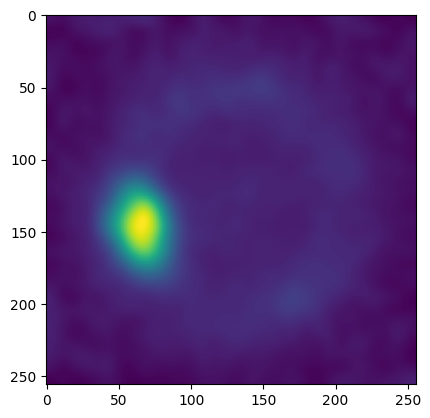

In [251]:
plt.imshow(preds[0])

In [ ]:
self = algo_class.PatchCore_list[0]

for ind, (images, masks, _, _) in tqdm(enumerate(dataloader_novel_test), total=len(dataloader_novel_test)):
    torch.cuda.empty_cache()
    break
    
with torch.no_grad():
    features, patch_shapes = self._embed(images.to(self.device), provide_patch_shapes=True)
    features = np.asarray(features)

In [287]:
query_features.shape

(1024, 8192)

In [297]:

query_features = self.anomaly_scorer.feature_merger.merge([features])
distances = self.anomaly_scorer.nn_method.search_index.search(query_features, 1)


In [290]:
distances[0]

array([[0.40787816],
       [0.16436243],
       [0.52230835],
       ...,
       [0.41100454],
       [0.42927408],
       [0.617892  ]], dtype=float32)

In [318]:
from scipy.spatial.distance import cdist
dists = cdist(query_features, raw_features)

In [320]:
dists.min(1)

array([0.63865324, 0.40541471, 0.72270925, ..., 0.64109909, 0.65519513,
       0.78605893])

In [315]:
def find_nearest_neighbors(query_features, raw_features, k=1):
    from scipy.spatial.distance import cdist
    cdist()
    return indices, distances

In [291]:
raw_features = self.anomaly_scorer.nn_method.raw_features

In [308]:
dir(algo_class.PatchCore_list[0].featuresampler)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_compute_batchwise_cosine_distance',
 '_compute_batchwise_differences',
 '_compute_batchwise_euclidean_distances_new',
 '_compute_euclidean_distances_original',
 '_compute_greedy_coreset_indices',
 '_compute_minkowski_distance',
 '_reduce_features',
 '_restore_type',
 '_store_type',
 'coreset_search_dimension_map',
 'coreset_size',
 'device',
 'distance_type',
 'features_is_numpy',
 'number_of_starting_points',
 'run']

In [313]:
distances_new_ = algo_class.PatchCore_list[0].featuresampler._compute_batchwise_differences(torch.tensor(query_features),
                                                                                              torch.tensor(raw_features), 
                                                                                              )
distances_new = distances_new_.min(1).values

In [310]:
distances[0]/distances[0][0]

array([[1.        ],
       [0.40296942],
       [1.2805499 ],
       ...,
       [1.007665  ],
       [1.0524566 ],
       [1.5148937 ]], dtype=float32)

In [314]:
distances_new/distances_new[0]

tensor([1.0000, 0.6348, 1.1316,  ..., 1.0038, 1.0259, 1.2308])

In [238]:
batchsize = images.shape[0]

In [234]:
patch_shapes

[[32, 32], [16, 16]]

In [264]:
print(features.shape)
query_features = self.anomaly_scorer.feature_merger.merge(
    features,
)
print(query_features.shape)

(8192, 1024)
(1024, 8192)


In [233]:
features.shape

(8192, 1024)

In [236]:
patch_scores = image_scores = self.anomaly_scorer.predict([features])[0]
patch_scores = self.patch_maker.unpatch_scores(
    patch_scores, batchsize=images.shape[0]
)



In [239]:
scales = patch_shapes[0]
patch_scores = patch_scores.reshape(batchsize, scales[0], scales[1])

patch_score_final = self.anomaly_segmentor.convert_to_segmentation(patch_scores)


In [243]:
patch_score_final[0].shape

(256, 256)

In [259]:
self.anomaly_scorer.predict([features])[0]

array([0.40787816, 0.16436243, 0.52230835, ..., 0.41100454, 0.42927408,
       0.617892  ], dtype=float32)

In [266]:
features.shape

(8192, 1024)

In [268]:
distances = algo_class.PatchCore_list[0].featuresampler._compute_euclidean_distances_original(torch.tensor(features),
                                                                                              torch.tensor(raw_features), 
                                                                                              )
patch_scores_new = distances.min(1).values.numpy()
patch_scores_new

array([0.63865805, 0.40542284, 0.7227087 , ..., 0.6410997 , 0.6551956 ,
       0.78605866], dtype=float32)

In [269]:
distances.shape

torch.Size([8192, 25000])

In [326]:
distances.min(1).values.numpy()

array([1.8763883, 1.6033039, 1.6863023, ..., 1.711793 , 1.6403041,
       1.8708127], dtype=float32)

In [262]:
patch_scores_new/self.anomaly_scorer.predict([features])[0]

array([1.5658059, 2.4666393, 1.3836821, ..., 1.559836 , 1.5262873,
       1.2721618], dtype=float32)

In [329]:
((raw_features/raw_features.max(1)[:,None])).max(1).shape

(25000,)

In [321]:
raw_features = algo_class.PatchCore_list[0].anomaly_scorer.nn_method.raw_features
distances = algo_class.PatchCore_list[0].featuresampler._compute_euclidean_distances_original(torch.tensor(features),
                                                                                              torch.tensor(raw_features/raw_features.max(1)[:,None]), 
                                                                                              )
# patch_scores_new = distances.min(1).values.numpy()
# patch_scores_new = self.patch_maker.unpatch_scores(
#     patch_scores_new, batchsize=images.shape[0]
# )

In [253]:
distances.shape

torch.Size([8192, 25000])

In [254]:
patch_scores_new = distances.min(1).values.numpy()

In [255]:
patch_scores_new.shape

(8192,)

In [256]:
patch_scores_new_shapes = self.patch_maker.unpatch_scores(
    patch_scores_new, batchsize=batchsize
)

In [274]:
final_new = patch_scores_new.reshape(8, 32, 32)[0]

In [279]:
patch_scores[0]/patch_scores[0].max()==final_new/final_new.max()

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [281]:
final_new/final_new.max()

array([[0.24951686, 0.15839437, 0.28235456, ..., 0.01948246, 0.17795148,
        0.01111367],
       [0.01271998, 0.01537534, 0.23536381, ..., 0.23042731, 0.0088578 ,
        0.26142058],
       [0.18294853, 0.23369607, 0.01136941, ..., 0.01344056, 0.22249824,
        0.25228432],
       ...,
       [0.27999562, 0.22539662, 0.28635383, ..., 0.22672085, 0.19013149,
        0.02263778],
       [0.25287074, 0.01514641, 0.2336805 , ..., 0.02461698, 0.22680914,
        0.17457876],
       [0.0080507 , 0.17921838, 0.01939822, ..., 0.25058264, 0.25644806,
        0.3072407 ]], dtype=float32)

In [280]:
patch_scores[0]/patch_scores[0].max()

array([[6.2258031e-02, 2.5088083e-02, 7.9724513e-02, ..., 3.8240635e-04,
        3.1668399e-02, 1.2376893e-04],
       [1.6216241e-04, 2.4047784e-04, 5.5394184e-02, ..., 5.3095527e-02,
        8.2100181e-05, 6.8341561e-02],
       [3.3470962e-02, 5.4616418e-02, 1.3319444e-04, ..., 1.7846600e-04,
        4.9502626e-02, 6.3647076e-02],
       ...,
       [7.8398392e-02, 5.0805893e-02, 8.2000032e-02, ..., 5.1405922e-02,
        3.6149554e-02, 5.1385397e-04],
       [6.3946217e-02, 2.2868685e-04, 5.4605208e-02, ..., 6.0949195e-04,
        5.1445954e-02, 3.0477509e-02],
       [6.5250722e-05, 3.2121696e-02, 3.7789374e-04, ..., 6.2793978e-02,
        6.5768287e-02, 9.4397634e-02]], dtype=float32)

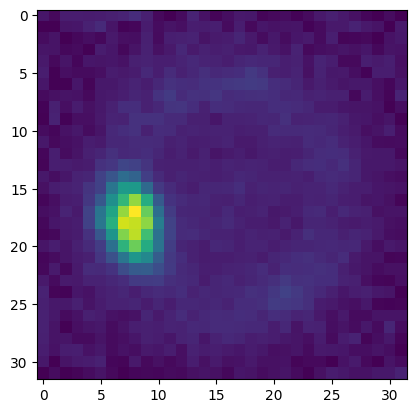

In [276]:
plt.imshow(patch_scores[0])

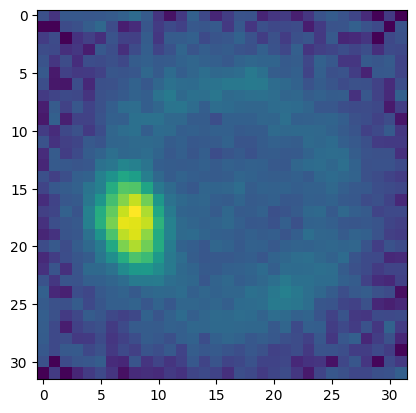

In [271]:
plt.imshow(patch_scores_new.reshape(8, 32, 32)[0])

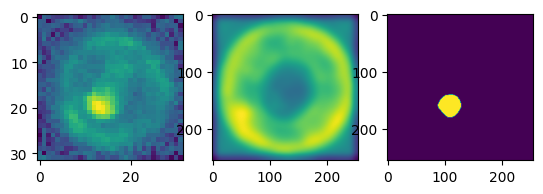

In [246]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(patch_scores_new.reshape(8, 32, 32)[0])
axes[1].imshow(patch_score_final[0])
# axes[1].imshow(patch_scores.reshape(8, 32, 32, order='C')[2])

axes[2].imshow(np.array(masks[0, 0]))

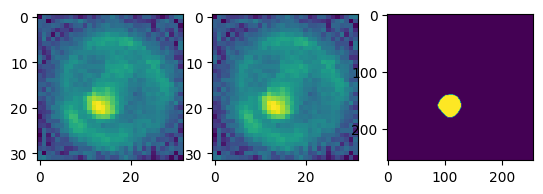

In [210]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(patch_scores_new.reshape(8, 32, 32)[0])
axes[1].imshow(patch_scores_new[0].reshape(32, 32))
axes[2].imshow(np.array(masks[0, 0]))

In [173]:
type(raw_features)

numpy.ndarray

In [186]:
patch_scores_new = distances.min(0).values.numpy()

In [187]:
patch_scores_new

array([0.02268801, 0.67212903, 0.57341474, ..., 0.04525501, 0.4377114 ,
       0.05509362], dtype=float32)

In [185]:
patch_scores

array([1.9594028, 2.4328144, 2.4564865, ..., 2.3861065, 2.394005 ,
       1.9362416], dtype=float32)

In [ ]:
_predict(algo_class.PatchCore_list[0], images)

In [ ]:
features, patch_shapes = self._embed(images, provide_patch_shapes=True)
features = np.asarray(features)

In [190]:
patch_scores_new = self.patch_maker.unpatch_scores(
    patch_scores_new, batchsize=images.shape[0]
)

In [ ]:
patch_scores = self.patch_maker.unpatch_scores(
    patch_scores, batchsize=images.shape[0]
)

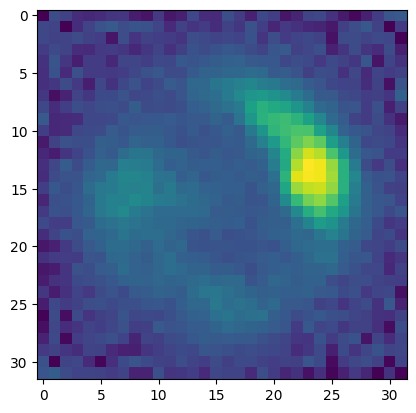

In [194]:
import matplotlib.pyplot as plt
plt.imshow(patch_scores_new[0].reshape(32, 32))

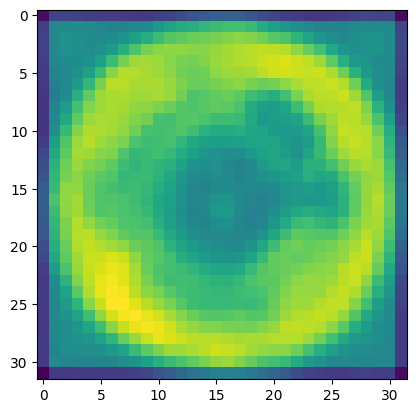

In [193]:
import matplotlib.pyplot as plt
plt.imshow(patch_scores[0].reshape(32, 32))

In [191]:
1024**0.5

32.0

In [ ]:
patch_scores_new

In [189]:
patch_scores.shape

(8, 1024)

In [ ]:
def _predict(self, images):
    """Infer score and mask for a batch of images."""
    images = images.to(torch.float).to(self.device)
    _ = self.forward_modules.eval()

    batchsize = images.shape[0]
    with torch.no_grad():
        features, patch_shapes = self._embed(images, provide_patch_shapes=True)
        features = np.asarray(features)

        patch_scores = image_scores = self.anomaly_scorer.predict([features])[0]
        image_scores = self.patch_maker.unpatch_scores(
            image_scores, batchsize=batchsize
        )
        image_scores = image_scores.reshape(*image_scores.shape[:2], -1)
        image_scores = self.patch_maker.score(image_scores)

        patch_scores = self.patch_maker.unpatch_scores(
            patch_scores, batchsize=batchsize
        )
        scales = patch_shapes[0]
        patch_scores = patch_scores.reshape(batchsize, scales[0], scales[1])

        masks = self.anomaly_segmentor.convert_to_segmentation(patch_scores)

    return torch.tensor(np.array(image_scores)), torch.tensor(np.array(masks))

features.shape torch.Size([214016, 128])


Subsampling...: 100%|█| 25000/25000 [00:18<0


CoresetSampler distance type:  euclidean
FaissNN distance type:  euclidean
len(loaded_patchcores): 1


100%|█████████| 8/8 [01:22<00:00, 10.28s/it]


Pixelwise_AUC:
	segmentations: 0.9880018174242683

Metric time taken:

Pixelwise_AUC: 2.7s
Not saved the metrics results


{'Pixelwise_AUC': {'metric_results': {'segmentations': 0.9880018174242683},
  'metric_data': {'segmentations': {}}}}

In [ ]:
# make the unet perform a weighted combination
#